# UdaciSense: Optimized Object Recognition - Google Colab Version

## Notebook 1: Baseline Performance

In this notebook, you'll establish the baseline performance of the computer vision model. This will serve as the reference point for your optimization efforts.

Remember, the CTO has set specific requirements:
- The optimized model should be **30% smaller** than the baseline
- The optimized model should **reduce inference time by 40%**
- The optimized model should **maintain accuracy within 5%** of the baseline

### Step 0: Colab Setup (Clone Repository and Install Dependencies)

In [3]:
# Clone the repository to get all files and dependencies
!git clone https://github.com/Imsharad/udaci-model-optimization.git


Cloning into 'udaci-model-optimization'...
remote: Enumerating objects: 6090, done.
remote: Counting objects: 100% (6090/6090), done.
remote: Compressing objects: 100% (6078/6078), done.
remote: Total 6090 (delta 12), reused 6086 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (6090/6090), 40.06 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (6050/6050), done.
Filtering content: 100% (2/2), 309.23 MiB | 58.19 MiB/s, done.
/content/udaci-model-optimization/project/starter-kit/udaci-model-optimization/project/starter-kit/udaci-model-optimization/project/starter-kit


In [5]:

%cd udaci-model-optimization/project/starter-kit/

/content/udaci-model-optimization/project/starter-kit


In [6]:
# Install UV for faster package management\n
!curl -LsSf https://astral.sh/uv/install.sh | sh\n!source $HOME/.cargo/env
# Install PyTorch with CUDA support using UV (much faster)\n
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --system

/bin/bash: line 1: shn!source: command not found
curl: (23) Failure writing output to destination
Using Python 3.11.13 environment at: /usr
Audited 3 packages in 102ms


In [7]:
# Install remaining dependencies with UV (faster than pip)\n
!uv pip install matplotlib seaborn pandas scikit-learn pillow tqdm thop plotly tensorboard --system

Using Python 3.11.13 environment at: /usr
Audited 9 packages in 75ms


### Step 1. Set up the environment

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset

# Import custom modules
from utils import MAX_ALLOWED_ACCURACY_DROP, TARGET_INFERENCE_SPEEDUP, TARGET_MODEL_COMPRESSION
from utils.data_loader import get_household_loaders, get_input_size, print_dataloader_stats, visualize_batch
from utils.model import MobileNetV3_Household, load_model, print_model_summary, train_model
from utils.evaluation import calculate_confusion_matrix, evaluate_model_metrics
from utils.visualization import plot_confusion_matrix, plot_training_history, plot_weight_distribution

In [10]:
# Check if CUDA is available
devices = ["cpu"]
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    devices.extend([f"cuda:{i} ({torch.cuda.get_device_name(i)})" for i in range(num_devices)])
print(f"Devices available: {devices}")

# Set device to cuda, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Devices available: ['cpu', 'cuda:0 (Tesla T4)']
Using device: cuda


In [11]:
# Set random seed for reproducibility
def set_deterministic_mode(seed):
    # Basic seed setting
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make cudnn deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # For some PyTorch operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # For DataLoader workers
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    return seed_worker

set_deterministic_mode(42)
g = torch.Generator()
g.manual_seed(42)

In [12]:
# Create directories
model_type = "baseline_mobilenet"
models_dir = f"../models/{model_type}"
models_ckp_dir = f"{models_dir}/checkpoints"
results_dir = f"../results/{model_type}"

os.makedirs(models_ckp_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

### Step 2. Load the dataset

Extracting household classes from CIFAR100 for train set...
Extracting household classes from CIFAR100 for test set...
Datasets have these classes: 
  0: clock
  1: keyboard
  2: lamp
  3: telephone
  4: television
  5: bed
  6: chair
  7: couch
  8: table
  9: wardrobe

Information on train set
Statistics for train
 Size: 5000
 Samples per class:
  clock: 500
  keyboard: 500
  lamp: 500
  telephone: 500
  television: 500
  bed: 500
  chair: 500
  couch: 500
  table: 500
  wardrobe: 500
Examples of images from the train set


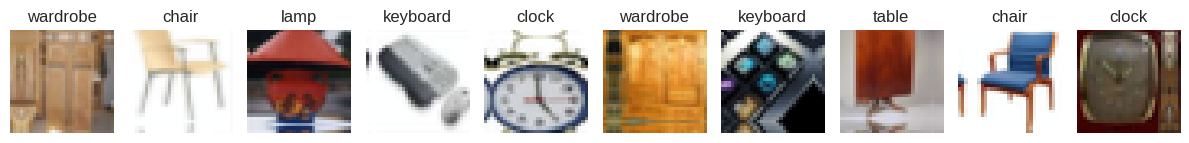


Information on test set
Statistics for test
 Size: 1000
 Samples per class:
  clock: 100
  keyboard: 100
  lamp: 100
  telephone: 100
  television: 100
  bed: 100
  chair: 100
  couch: 100
  table: 100
  wardrobe: 100
Examples of images from the test set


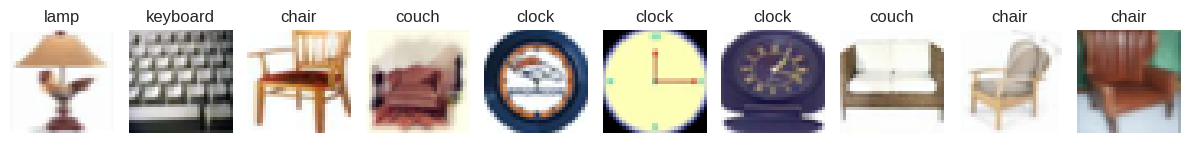

In [13]:
# Load household objects dataset
train_loader, test_loader = get_household_loaders(
    image_size="CIFAR", batch_size=128, num_workers=2,
)

# Get class names
class_names = train_loader.dataset.classes
print(f"Datasets have these classes: ")
for i in range(len(class_names)):
    print(f"  {i}: {class_names[i]}")

# Visualize some examples
for dataset_type, data_loader in [('train', train_loader), ('test', test_loader)]:
    print(f"\nInformation on {dataset_type} set")
    print_dataloader_stats(data_loader, dataset_type)
    print(f"Examples of images from the {dataset_type} set")
    visualize_batch(data_loader, num_images=10)

### Step 3. Train the baseline model

In [14]:
# Initialize model
model = MobileNetV3_Household().to(device)
print_model_summary(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 90.0MB/s]


Model Architecture:
MobileNetV3_Household(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
   

In [15]:
# Define training configuration
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,  # Note that MobileNet is sensitive to high LRs
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.005,  # Peak learning rate
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,  # Spend 30% of training time warming up
    div_factor=25,  # Initial LR is max_lr/25
    final_div_factor=1000  # Final LR is max_lr/1000
)

training_config = {
    'num_epochs': num_epochs,
    'criterion': criterion,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'patience': 5,
    'device': device
}

In [ ]:
# Train model given the training_config
training_stats, best_accuracy, best_epoch = train_model(
    model,
    train_loader,
    test_loader,
    training_config,
    checkpoint_path=f"{models_ckp_dir}/model.pth",
)

# Save training statistics
with open(f"{results_dir}/training_stats.json", 'w') as f:
    json.dump(training_stats, f, indent=4)

Total parameters: 1,528,106
Training with standard method for 50 epochs


Epoch 1/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 19.16it/s, loss=1.4, acc=64]


Epoch 1/50 - Train Loss: 1.5927, Train Acc: 52.76%, Test Loss: 1.0530, Test Acc: 64.00%, LR: 0.000200, Time: 8.03s
New best model! Saving... (64.00%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 2/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 20.05it/s, loss=1.26, acc=73.3]


Epoch 2/50 - Train Loss: 0.7680, Train Acc: 74.08%, Test Loss: 0.7845, Test Acc: 73.30%, LR: 0.000200, Time: 5.18s
New best model! Saving... (73.30%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 3/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 20.70it/s, loss=0.846, acc=78.9]


Epoch 3/50 - Train Loss: 0.5284, Train Acc: 81.80%, Test Loss: 0.6347, Test Acc: 78.90%, LR: 0.000200, Time: 5.52s
New best model! Saving... (78.90%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 4/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 20.13it/s, loss=0.906, acc=79.9]


Epoch 4/50 - Train Loss: 0.3901, Train Acc: 86.34%, Test Loss: 0.5662, Test Acc: 79.90%, LR: 0.000201, Time: 5.21s
New best model! Saving... (79.90%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 5/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 19.81it/s, loss=0.86, acc=80.7]


Epoch 5/50 - Train Loss: 0.3010, Train Acc: 89.80%, Test Loss: 0.5372, Test Acc: 80.70%, LR: 0.000201, Time: 5.51s
New best model! Saving... (80.70%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 6/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 19.46it/s, loss=0.805, acc=82.6]


Epoch 6/50 - Train Loss: 0.2510, Train Acc: 91.58%, Test Loss: 0.5028, Test Acc: 82.60%, LR: 0.000201, Time: 5.25s
New best model! Saving... (82.60%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 7/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 15.01it/s, loss=0.487, acc=83.3]


Epoch 7/50 - Train Loss: 0.2213, Train Acc: 92.56%, Test Loss: 0.4873, Test Acc: 83.30%, LR: 0.000202, Time: 5.46s
New best model! Saving... (83.30%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 8/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 20.43it/s, loss=0.681, acc=84]


Epoch 8/50 - Train Loss: 0.1739, Train Acc: 94.28%, Test Loss: 0.5106, Test Acc: 84.00%, LR: 0.000202, Time: 5.41s
New best model! Saving... (84.00%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 9/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 19.69it/s, loss=0.678, acc=85.8]


Epoch 9/50 - Train Loss: 0.1394, Train Acc: 95.72%, Test Loss: 0.4240, Test Acc: 85.80%, LR: 0.000203, Time: 5.32s
New best model! Saving... (85.80%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 10/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s, loss=0.676, acc=86.6]


Epoch 10/50 - Train Loss: 0.1082, Train Acc: 96.58%, Test Loss: 0.4224, Test Acc: 86.60%, LR: 0.000203, Time: 5.76s
New best model! Saving... (86.60%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 11/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 19.93it/s, loss=0.731, acc=85.9]


Epoch 11/50 - Train Loss: 0.1041, Train Acc: 96.68%, Test Loss: 0.4568, Test Acc: 85.90%, LR: 0.000204, Time: 5.34s


Epoch 12/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 18.94it/s, loss=0.719, acc=87.4]


Epoch 12/50 - Train Loss: 0.1214, Train Acc: 96.08%, Test Loss: 0.4495, Test Acc: 87.40%, LR: 0.000205, Time: 6.13s
New best model! Saving... (87.40%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 13/50 [Test]: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.727, acc=87.8]


Epoch 13/50 - Train Loss: 0.0937, Train Acc: 96.92%, Test Loss: 0.4543, Test Acc: 87.80%, LR: 0.000206, Time: 5.41s
New best model! Saving... (87.80%)
Model saved to ../models/baseline_mobilenet/checkpoints/model.pth


Epoch 14/50 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

### Step 4. Evaluate the baseline model

In [ ]:
# Load the best model
model = load_model(f"{models_ckp_dir}/model.pth", device)

# Define evaluation input and output variables
class_names = test_loader.dataset.classes
n_classes = len(class_names)
input_size = get_input_size("CIFAR")

# Calculate and save model performance on all metrics
print("Evaluating model's performance on all metrics...")
baseline_metrics = evaluate_model_metrics(model, test_loader, device, n_classes, class_names, input_size, save_path=f"{results_dir}/metrics.json")

# Calculate, plot, and save confusion matrix
confusion_matrix = calculate_confusion_matrix(model, test_loader, device, n_classes)
_ = plot_confusion_matrix(confusion_matrix, class_names, f"{results_dir}/confusion_matrix.png")

# Plot and save training history
_ = plot_training_history(training_stats, f"{results_dir}/training_history.png")

# Plot weight distribution (can help guide optimization strategies)
_ = plot_weight_distribution(model, output_path=f"{results_dir}/weight_distribution.png")

### Step 5. Identify potential optimization approaches
Based on our baseline analysis, let's identify promising optimization approaches.

In [ ]:
print(f"\nAll artifacts saved to:")
print(f" - Model: {models_ckp_dir}/model.pth")
print(f" - Metrics: {results_dir}/metrics.json")
print(f" - Confusion Matrix: {results_dir}/confusion_matrix.png")
print(f" - Training History: {results_dir}/training_history.png")
print(f" - Training Stats: {results_dir}/training_stats.json")
print(f" - Weight Distribution: {results_dir}/weight_distribution.png")

In [ ]:
# Calculate target metrics based on CTO requirements
target_model_size = baseline_metrics['size']['model_size_mb'] * (1 - TARGET_MODEL_COMPRESSION)
target_inference_time_cpu = baseline_metrics['timing']['cpu']['avg_time_ms'] * (1 - TARGET_INFERENCE_SPEEDUP)
if torch.cuda.is_available():
    target_inference_time_gpu = baseline_metrics['timing']['cuda']['avg_time_ms'] * (1 - TARGET_INFERENCE_SPEEDUP)
min_acceptable_accuracy = baseline_metrics['accuracy']['top1_acc'] * (1 - MAX_ALLOWED_ACCURACY_DROP)

print("Optimization Targets:")
print(f"Target Model Size: {baseline_metrics['size']['model_size_mb']:.2f} --> {target_model_size:.2f} MB ({TARGET_MODEL_COMPRESSION*100}% reduction)")
print(f"Target Inference Time (CPU): {baseline_metrics['timing']['cpu']['avg_time_ms']:.2f} --> {target_inference_time_cpu:.2f} ms ({TARGET_INFERENCE_SPEEDUP*100}% reduction)")
if torch.cuda.is_available():
    print(f"Target Inference Time (GPU): {baseline_metrics['timing']['cuda']['avg_time_ms']:.2f} --> {target_inference_time_gpu:.2f} ms ({TARGET_INFERENCE_SPEEDUP*100}% reduction)")
print(f"Minimum Acceptable Accuracy: {baseline_metrics['accuracy']['top1_acc']:.2f} --> {min_acceptable_accuracy:.2f} (within {MAX_ALLOWED_ACCURACY_DROP*100}% of baseline)")

---------

**TODO: Analyze the baseline results and select appropriate compression techniques**

Now that you've established the baseline performance metrics for the UdaciSense object recognition model, complete an analysis that explores the optimization potential for this specific model architecture.

Consider these guiding questions:
- What is the baseline performance we need to optimize from?
- What characteristics of MobileNetV3 affect its optimization potential?
- Which compression techniques are most promising for this architecture and why?
- What trade-offs do you anticipate between size, speed, and accuracy?
- How might different techniques complement each other in a multi-stage approach?

Provide a well-reasoned analysis that includes recommendations for at least two specific compression techniques to implement in the next notebook.

# Optimization Analysis for UdaciSense Computer Vision Model

*(Replace this with your analysis)*

> 🚀 **Next Step:**
> Experiment with the compression techniques you've chosen in notebook `02_compression.ipynb`  